In [ ]:
import pandas as pd
from tqdm import tqdm
from textblob import TextBlob
from nltk.sentiment import SentimentIntensityAnalyzer
from transformers import pipeline

import os
os.environ["TRANSFORMERS_NO_TF"] = "1"  # Important fix

# Load dataset
df = pd.read_csv("data.csv")

# Initialize analyzers
sia = SentimentIntensityAnalyzer()
bert_classifier = pipeline(
    "sentiment-analysis",
    model="distilbert/distilbert-base-uncased-finetuned-sst-2-english",
    revision="714eb0f",
    framework="pt"
)


# TextBlob sentiment (scaled 0-1)
def textblob_score(text):
    try:
        return (TextBlob(text).sentiment.polarity + 1) / 2
    except:
        return 0.5

# VADER compound score (scaled 0-1)
def vader_score(text):
    try:
        return (sia.polarity_scores(text)['compound'] + 1) / 2
    except:
        return 0.5

# BERT (Transformer) sentiment
def bert_score(text):
    try:
        result = bert_classifier(text[:512])[0]  # max 512 tokens
        score = result['score']
        return score if result['label'] == 'POSITIVE' else 1 - score
    except:
        return 0.5

# Apply all with progress
tqdm.pandas(desc="Analyzing Sentiment")


df['textblob'] = df['review_description'].astype(str).progress_apply(textblob_score)
df['vader'] = df['review_description'].astype(str).progress_apply(vader_score)
df['bert'] = df['review_description'].astype(str).progress_apply(bert_score)

# Scaled rating
df['rating_scaled'] = df['review_rating'].apply(lambda x: min(float(x), 5.0)/5.0 if pd.notnull(x) else 0.5)



In [ ]:

# Final sentiment as average of all
df['final_sentiment'] = df[[ 'textblob', 'vader', 'bert', 'rating_scaled']].mean(axis=1)

# Group by product
product_sentiment = df.groupby('product_id')['final_sentiment'].mean().reset_index()
product_sentiment.columns = ['product_id', 'avg_sentiment_score']

# Label verdict
product_sentiment['verdict'] = product_sentiment['avg_sentiment_score'].apply(
    lambda x: 'Useful' if x > 0.705 else 'Not Useful'
)

# Save results
product_sentiment.to_csv("product_sentiment_analysis_combined.csv", index=False)

print("Combined sentiment analysis completed.")
print("Saved as: product_sentiment_analysis_combined.csv")

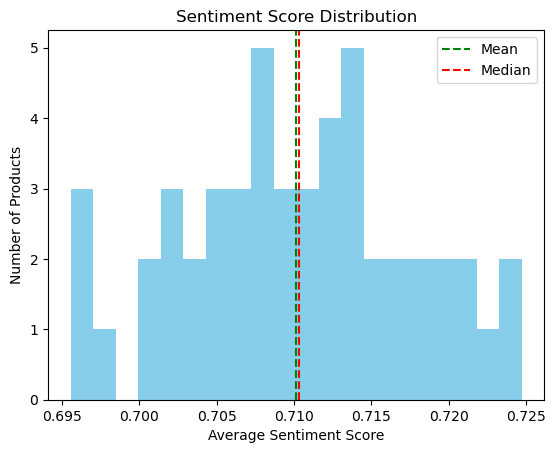

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Step 1: Load data
df = pd.read_csv("product_sentiment_analysis_combined.csv")

# Step 2: Plot histogram to visualize distribution
plt.hist(df['avg_sentiment_score'], bins=20, color='skyblue')
plt.axvline(df['avg_sentiment_score'].mean(), color='green', linestyle='--', label='Mean')
plt.axvline(df['avg_sentiment_score'].median(), color='red', linestyle='--', label='Median')
plt.xlabel('Average Sentiment Score')
plt.ylabel('Number of Products')
plt.title('Sentiment Score Distribution')
plt.legend()
plt.show()


In [ ]:
import pandas as pd

# Load the CSV
sentiment_df = pd.read_csv('product_sentiment_analysis_combined.csv')

# Calculate mean and standard deviation of sentiment scores
mean_score = sentiment_df['avg_sentiment_score'].mean()
std_dev = sentiment_df['avg_sentiment_score'].std()

# Define new threshold: mean - 1 * std deviation
new_threshold = mean_score - std_dev

# Apply new verdict based on threshold
sentiment_df['verdict'] = sentiment_df['avg_sentiment_score'].apply(
    lambda x: 'Useful' if x >= new_threshold else 'Not Useful'
)

# Check how many are in each category
verdict_counts = sentiment_df['verdict'].value_counts()

print(f"New threshold: {new_threshold:.4f}")
print("Verdict counts after applying new threshold:")
print(verdict_counts)

# Save the updated DataFrame back to the CSV
sentiment_df.to_csv('product_sentiment_analysis_combined.csv', index=False)


New threshold: 0.7028
Verdict counts after applying new threshold:
Useful        41
Not Useful     9
Name: verdict, dtype: int64
